##Assignment: Build a Smart Resume Parser

## Download the Resume Dataset



In [11]:
import kagglehub
import os
import random

dataset_path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")
print("Path to dataset files:", dataset_path)

data_folder = os.path.join(dataset_path, 'data', 'data', 'INFORMATION-TECHNOLOGY')
if not os.path.exists(data_folder):
    raise FileNotFoundError(f"Directory not found: {data_folder}")

Using Colab cache for faster access to the 'resume-dataset' dataset.
Path to dataset files: /kaggle/input/resume-dataset


##Pick 5 random PDFs

In [12]:
pdf_files = [f for f in os.listdir(data_folder) if f.lower().endswith(".pdf")]
random_pdfs = random.sample(pdf_files, min(5, len(pdf_files)))
print(f"Random 5 PDFs: {random_pdfs}")


Random 5 PDFs: ['46260230.pdf', '18067556.pdf', '11957080.pdf', '13385306.pdf', '24913648.pdf']



Displaying first page of: 46260230.pdf


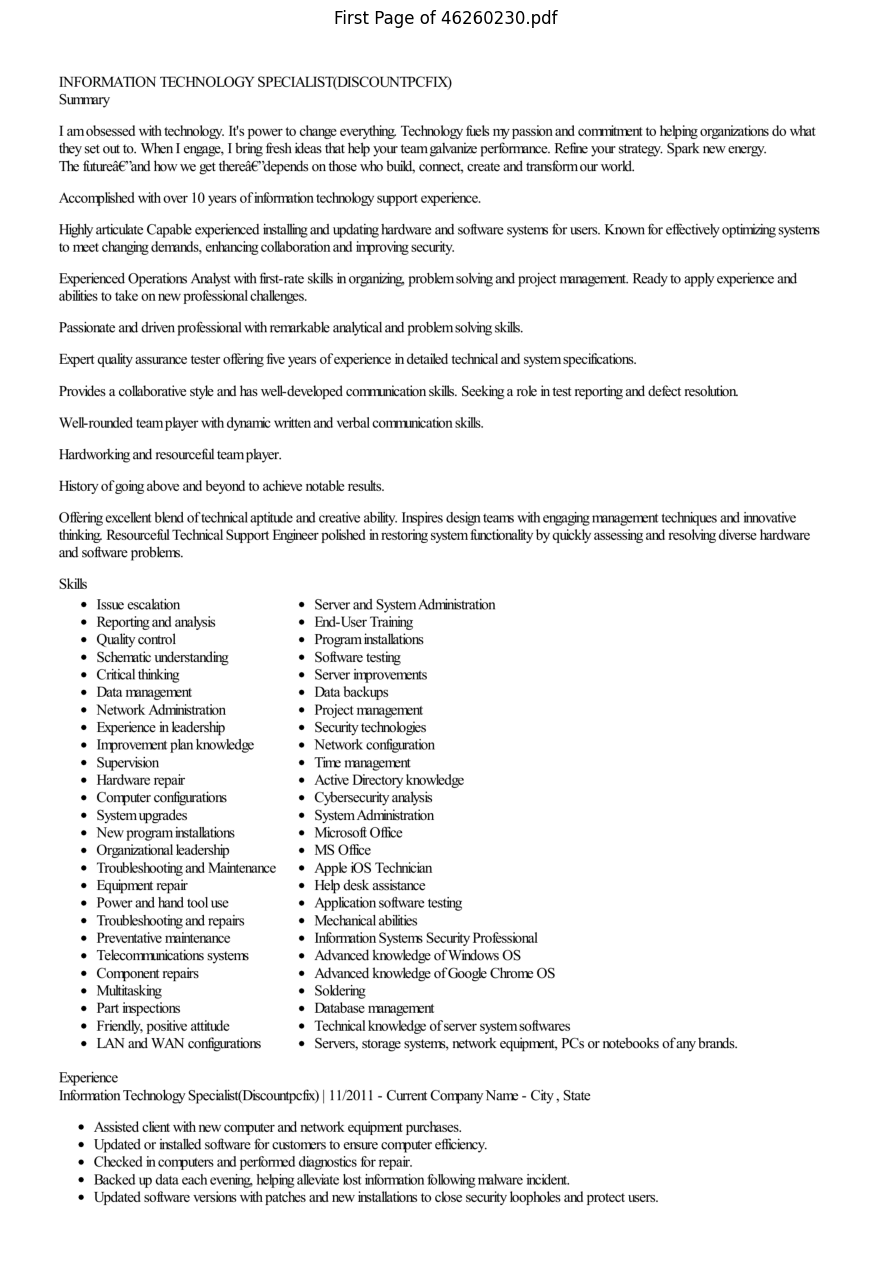


Displaying first page of: 18067556.pdf


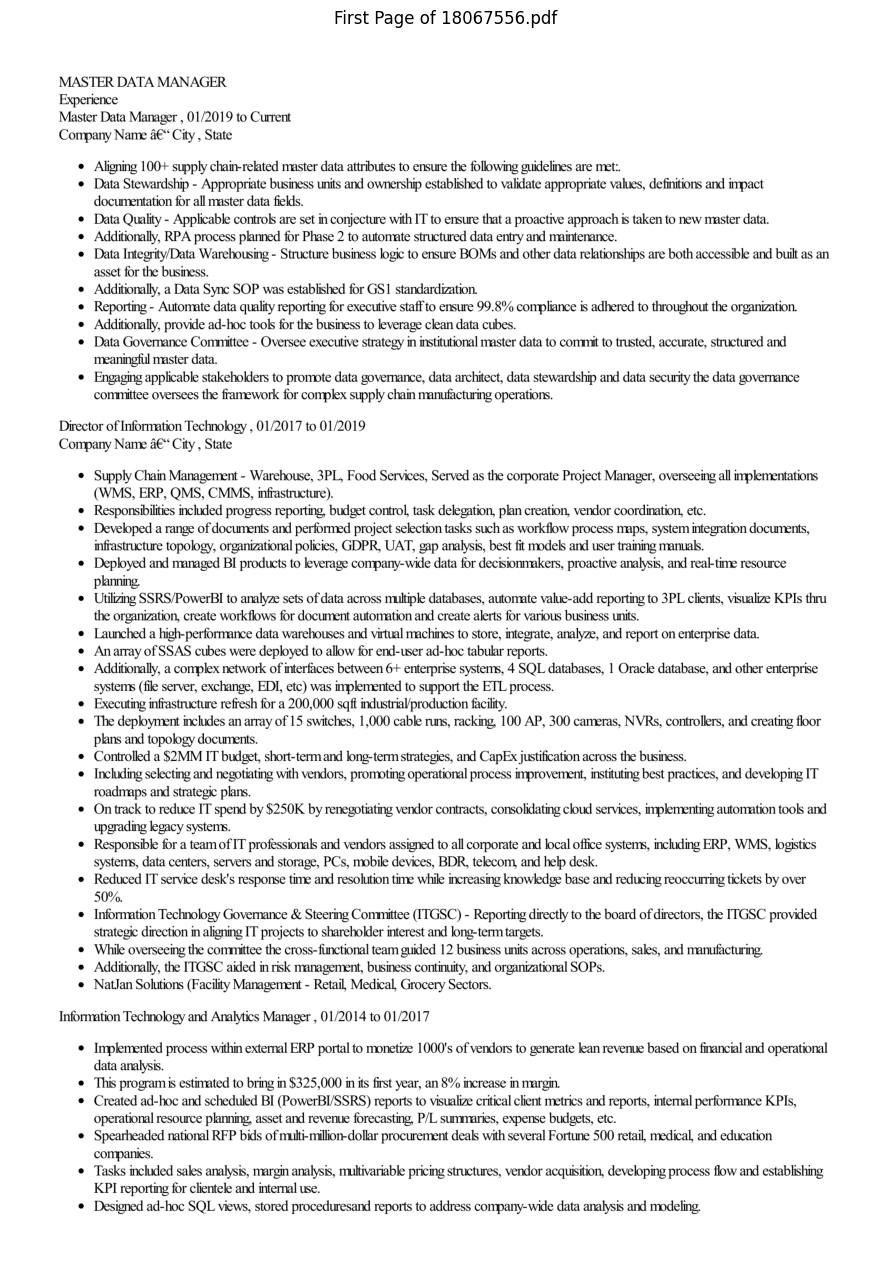


Displaying first page of: 11957080.pdf


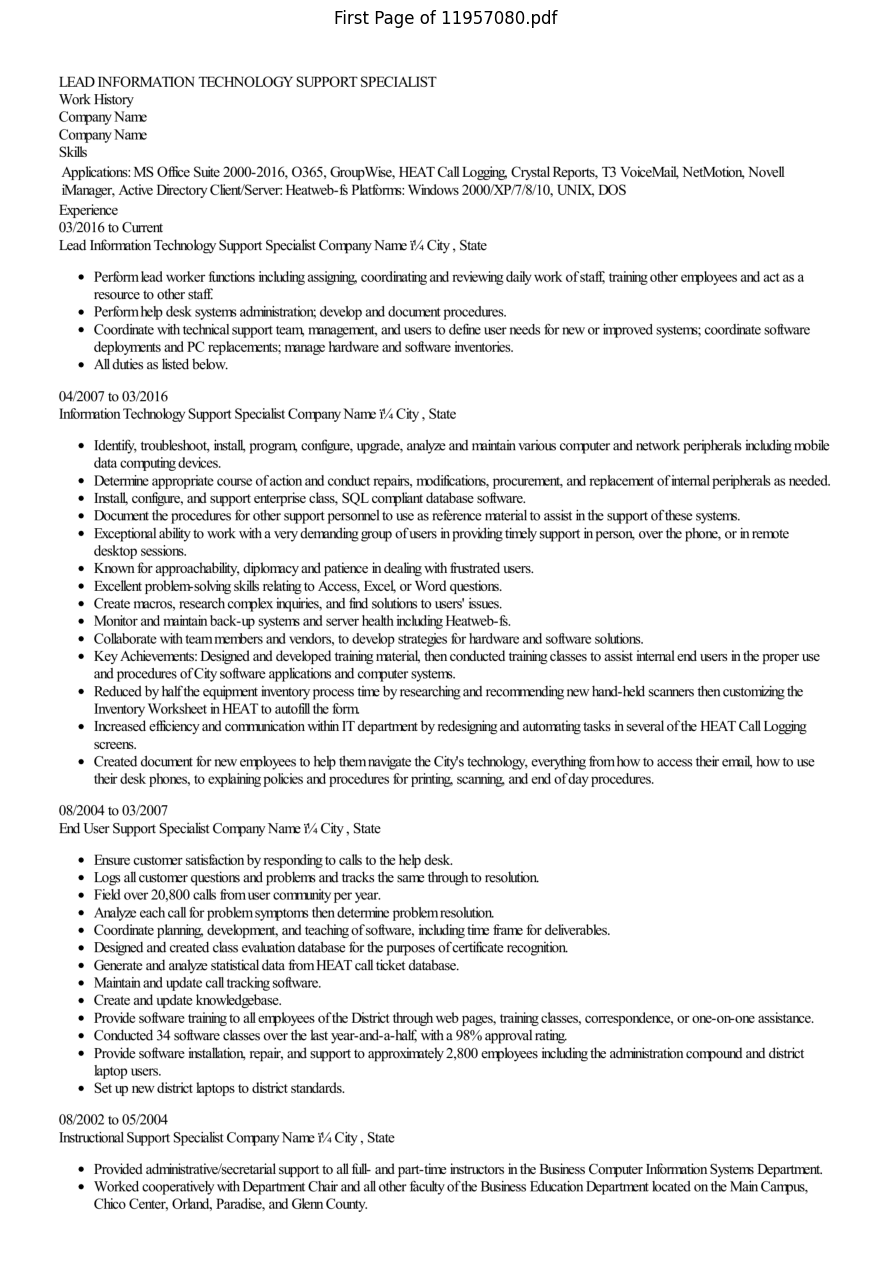


Displaying first page of: 13385306.pdf


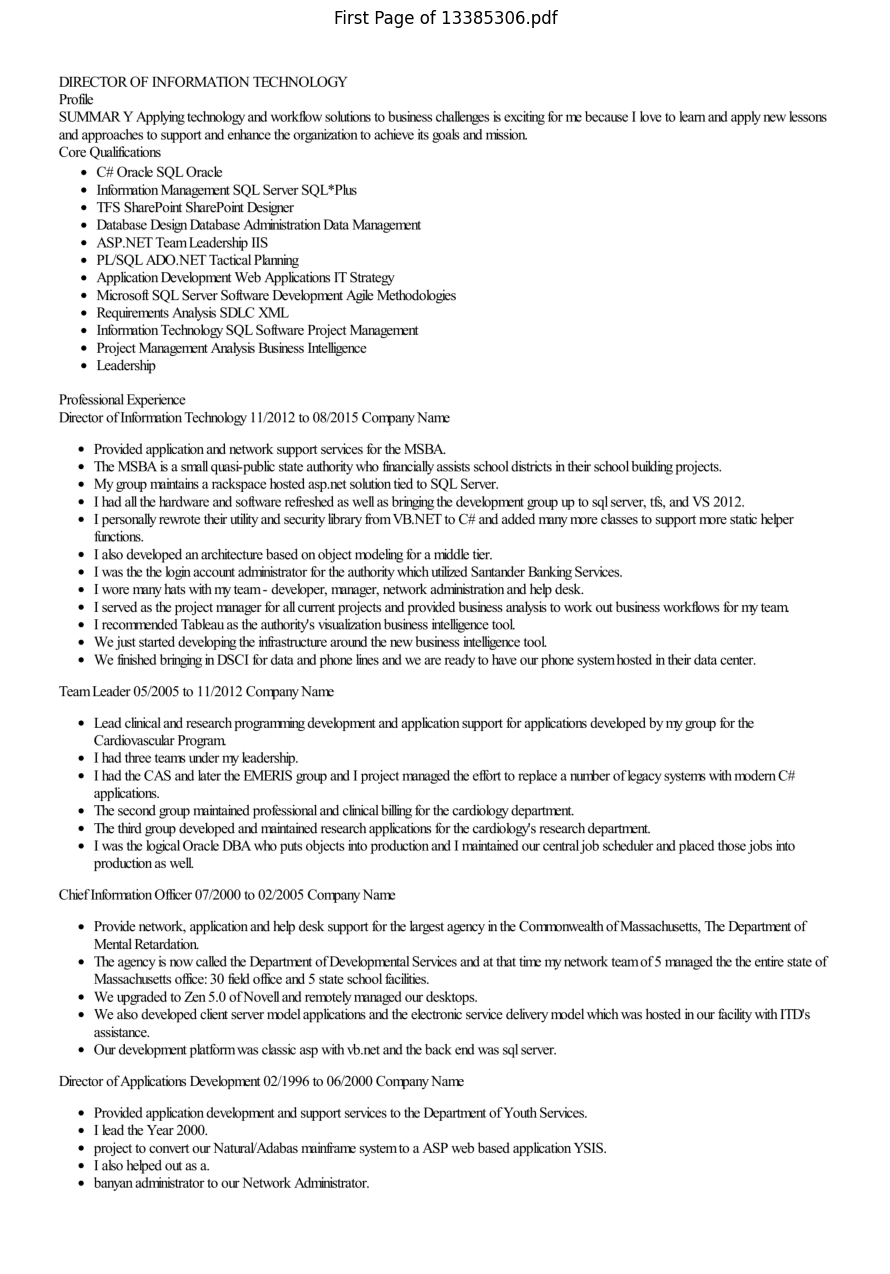


Displaying first page of: 24913648.pdf


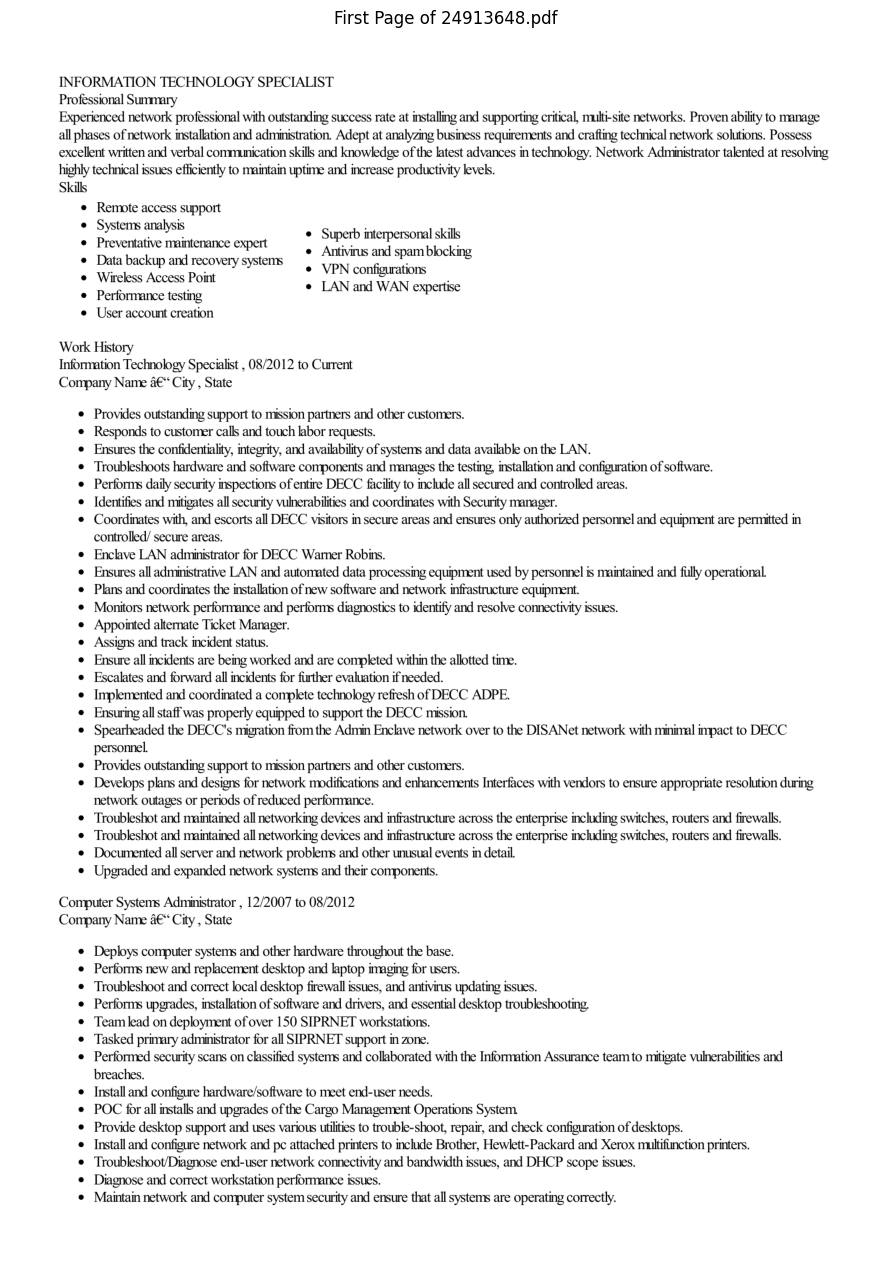

In [13]:
for pdf_file in random_pdfs:
    pdf_path = os.path.join(data_folder, pdf_file)
    print(f"\nDisplaying first page of: {pdf_file}")

    try:
        # Convert PDF to images
        images = convert_from_path(pdf_path)

        if images:
            plt.figure(figsize=(12, 16))
            plt.imshow(images[0])
            plt.axis('off')
            plt.title(f"First Page of {pdf_file}")
            plt.show()
    except Exception as e:
        print(f"Error displaying {pdf_file}: {e}")

##Install required packages

In [14]:
!pip install pdf2image pytesseract pillow
!apt-get install -q poppler-utils

from pdf2image import convert_from_path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image
import pytesseract
import json
import google.generativeai as genai
from google.colab import userdata
import pandas as pd
import time

Reading package lists...
Building dependency tree...
Reading state information...
poppler-utils is already the newest version (22.02.0-2ubuntu0.10).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


##Configure Gemini API

In [15]:
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

resume_prompt_template_v2 = """
Extract the key information from the provided resume text.
The text has been extracted from a PDF using OCR.
If some fields are missing, return `null`. Do not invent data.

Format:
{{
    "name": "Full Name" or null,
    "email": "email@address.com" or null,
    "phone": "123-456-7890" or null,
    "skills": ["Skill 1", "Skill 2"],
    "experience": [{{"company":"Company Name","role":"Job Title","duration":"Start - End"}}],
    "education": [{{"degree":"Degree Name","institution":"School Name","year":"YYYY"}}]
}}

Here is the text:

{extracted_text}
"""


##Image Preprocessing Functions

In [16]:
def preprocess_image(image):
    open_cv_image = np.array(image)[:, :, ::-1].copy()
    gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    binarized_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 4
    )
    coords = cv2.findNonZero(binarized_image)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1]
    if angle < -45: angle = -(90 + angle)
    else: angle = -angle
    (h, w) = gray_image.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    deskewed_image = cv2.warpAffine(gray_image, M, (w, h),
                                    flags=cv2.INTER_CUBIC,
                                    borderMode=cv2.BORDER_REPLICATE)
    return deskewed_image

##Function to extract structured info using Gemini

In [17]:
def extract_info_with_gemini(text):
    model = genai.GenerativeModel('gemini-2.5-flash')
    prompt = resume_prompt_template_v2.format(extracted_text=text)
    response = model.generate_content(prompt)
    cleaned_text = response.text.replace('```json', '').replace('```', '').strip()
    try:
        start_index = cleaned_text.find('{')
        end_index = cleaned_text.rfind('}') + 1
        if start_index == -1 or end_index == 0: return None
        return json.loads(cleaned_text[start_index:end_index])
    except:
        return None


##Process 5 Random PDFs

In [18]:
from tqdm import tqdm

all_extracted_data = []

for pdf_file in tqdm(random_pdfs, desc="Processing Resumes"):
    pdf_path = os.path.join(data_folder, pdf_file)

    # Convert PDF → images
    images = convert_from_path(pdf_path)

    # Preprocess images
    preprocessed_images = [preprocess_image(img) for img in images]

    # OCR all pages
    full_text = ""
    for img in preprocessed_images:
        pil_image = Image.fromarray(img)
        full_text += pytesseract.image_to_string(pil_image) + "\n\n--- Page Break ---\n\n"

    # Extract structured info
    data = extract_info_with_gemini(full_text)
    if data:
        data['file_name'] = pdf_file
        all_extracted_data.append(data)


Processing Resumes: 100%|██████████| 5/5 [03:47<00:00, 45.54s/it]


##Display results as a Table

In [19]:
df = pd.DataFrame(all_extracted_data)
df = df[['file_name','name','email','phone','skills','experience','education']]
df

,file_name,name,email,phone,skills,experience,education
0,46260230.pdf,None,None,None,"[Issue escalation, Server and System Administr...","[{'company': 'Company Nane', 'role': 'Quality ...",[{'degree': 'Associate of Science Science Tech...
1,18067556.pdf,None,None,None,"[Microsoft Office Suite, Office 365, Dynamics ...","[{'company': 'Company Name', 'role': 'Master D...",[{'degree': 'Bachelor of Science: Management o...
2,11957080.pdf,None,None,None,"[IT Support, Help Desk Systems Administration,...","[{'company': 'Company Name', 'role': 'Lead Inf...","[{'degree': 'BS : Business Administration, Man..."
3,13385306.pdf,None,None,None,"[ADO.NET, Agile Methodologies, Analysis, Appli...","[{'company': 'Company Name', 'role': 'Director...",None
4,24913648.pdf,None,None,None,"[Systems analysis, Preventative maintenance ex...","[{'company': 'Company Name', 'role': 'Informat...",[{'degree': 'Bachelor of Science: Computer Inf...


##Conclusion

Using an Intelligent Document Processing (IDP) pipeline, I processed 5 random resumes, converting PDFs to images, pre-processing them, performing OCR, and extracting structured data via Gemini AI. Key information such as skills, experience, and education was successfully captured in JSON format. Pre-processing improved OCR accuracy, and the pipeline demonstrates how IDP can automate resume screening efficiently, though processing time may increase for larger batches.